In [2]:
!pip install --upgrade "pyzmq<25" "jupyter_client<8"

  Using cached tornado-6.3.2-cp38-abi3-win_amd64.whl (428 kB)
  Attempting uninstall: tornado
    Found existing installation: tornado 6.1
    Uninstalling tornado-6.1:
      Successfully uninstalled tornado-6.1


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import dataframe_image as dfi
from scripts import helper
import os
from pathlib import Path

import os
import pandas as pd

In [12]:
df_tmp = pd.read_csv('wandb_export_2023-06-27_fmnist_lf-targeted.csv')
df_fedavg = df_tmp[df_tmp["aggregator_args.algorithm"] == "FedAvg"]

f1 = df_fedavg["Test/F1Score"]

f1.sem()

0.005130441205578309

In [25]:
import matplotlib.pyplot as plt

def get_plot_by_node_percent(data=None, fig=None, y_col=None, y_err=None, plt_title='No Title'):

    data.reset_index()
    df_mean = data.loc[: ,['aggregator_args.algorithm', 'adversarial_args.attack_env.poisoned_node_percent', y_col[0], y_err[0]]]

    #df_mean = data[['aggregator_args.algorithm', 'adversarial_args.attack_env.poisoned_node_percent', y_col, y_err]]

    # fig = plt.figure(figsize=(8, 6))
    fig = plt.figure()
    marker_styles = ['+', 'x', 'o']
    line_styles = ['-', '--', '-.', ':', '-']
    ax = None

    # Plot each aggregator's data
    for i, (aggregator, data) in enumerate(df_mean.groupby('aggregator_args.algorithm')):
        df_mean_agg = df_mean[df_mean['aggregator_args.algorithm'] == aggregator]
        ax = df_mean_agg.plot(x='adversarial_args.attack_env.poisoned_node_percent',
                              y=y_col,
                              yerr=y_err,
                              marker=marker_styles[i % len(marker_styles)],
                              markersize=6,
                              linestyle=line_styles[i % len(line_styles)],
                              linewidth=1,
                              label=aggregator,
                              ax=ax)

    # Set plot title and labels
    plt.title(plt_title, fontsize=10)
    plt.xlabel("Poisoned Node Percent", fontsize=10)
    plt.ylabel(y_col, fontsize=10)
    plt.ylim(0, 1)

    # Set legend
    plt.legend(fontsize=10)

    # Set grid
    plt.grid(True, linestyle='--', alpha=0.5)

    # Increase tick font sizes
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    return fig


def print_test():
    print("test")


In [26]:
root = os.path.abspath('')

data_file = "test_lf_untargeted.csv"
dataset = "mnist"
attack_name = "label_flipping_untargeted"
metric = 'Test/F1Score' # Test/F1Score', Test/ASR-targeted, Test/ASR-backdoor
raw_data = pd.read_csv(os.path.join(root, 'test_lf_untargeted.csv'))

metric_save = metric.replace("/", "-")
prefix = f'{dataset}_{attack_name}_{metric_save}'

In [27]:
raw_data['adversarial_args.attack_env.poisoned_sample_percent'] = raw_data['Group'].str.extract(r'-S(.*)_R')
raw_data['adversarial_args.attack_env.poisoned_sample_percent'].unique()
fixed_data = raw_data.astype({'adversarial_args.attack_env.poisoned_sample_percent': 'int64'})
# Sanity check
print(fixed_data["adversarial_args.attack_env.poisoned_sample_percent"].unique())
print(fixed_data["adversarial_args.attack_env.poisoned_node_percent"].unique())

benign = fixed_data[fixed_data['adversarial_args.attacks'] == 'No Attack']
df_unfinished = fixed_data[fixed_data['Round'] != 10]
if len(df_unfinished) > 0:
    print(df_unfinished)
    exit(0)

mean_benign = pd.pivot_table(benign, index=["aggregator_args.algorithm",
                                            "adversarial_args.attack_env.attack",
                                            "adversarial_args.attack_env.poisoned_node_percent",
                                            "adversarial_args.attack_env.poisoned_sample_percent",],
                             values=["Test/Accuracy","Test/F1Score", "Test/ASR-targeted", "Test/ASR-backdoor"], aggfunc = ['mean', 'sem'] , dropna=False)
mean_benign = mean_benign.reset_index()
num_attack_configs = len(mean_benign.index)

[ 30  50 100]
[10 50 80]


In [28]:
overview_mean = mean_benign.pivot(columns=["adversarial_args.attack_env.poisoned_node_percent", "adversarial_args.attack_env.poisoned_sample_percent"],
                                  index=["aggregator_args.algorithm"],
                                  values=('mean', metric))

overview_sem = mean_benign.pivot(columns=["adversarial_args.attack_env.poisoned_node_percent", "adversarial_args.attack_env.poisoned_sample_percent"],
                                 index=["aggregator_args.algorithm"],
                                 values=('sem', metric))

overview_mean = overview_mean.rename(columns={'adversarial_args.attack_env.poisoned_node_percent': 'poisoned_node_percent'})
overview_sem = overview_sem.rename(columns={'adversarial_args.attack_env.poisoned_node_percent': 'poisoned_node_percent'})
overview_mean_style = overview_mean.style.set_caption(f'{attack_name}: Mean {metric}')
if metric in ["Test/Accuracy","Test/F1Score"]:
    overview_mean_style.highlight_max()
else:
    overview_mean_style.highlight_min()

overview_sem_style = overview_sem.style.set_caption(f'{attack_name}: SEM {metric}')
overview_sem_style.highlight_max()

mean_file_name = f'{prefix}-_mean_overview.png'
sem_file_name = f'{prefix}-_sem_overview.png'

            sem
   Test/F1Score
0      0.009146
3      0.013794
6      0.024923
9      0.012889
12     0.012717
15     0.004262
18     0.009579
21     0.015729
24     0.010076
27     0.008447
30     0.014237
33     0.009170
36     0.008203
39     0.006663
42     0.028927


<Figure size 640x480 with 0 Axes>

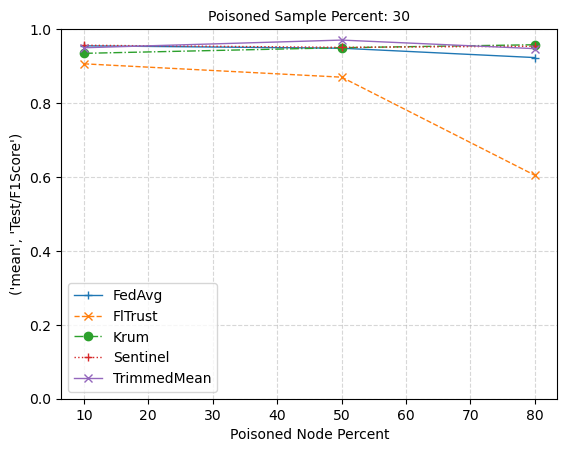

In [44]:
sample_percents = mean_benign['adversarial_args.attack_env.poisoned_sample_percent'].unique()
for percent in sample_percents:
    data_by_percent = mean_benign[mean_benign['adversarial_args.attack_env.poisoned_sample_percent'] == percent]
    plt_title = "Poisoned Sample Percent: " + str(percent)
    # percent_f1 = helper.get_plot_by_node_percent(data=data_by_percent, y_col='Test/F1Score', plt_title=str(percent))
    #percent_acc = get_plot_by_node_percent(data=data_by_percent, y_col=('mean', metric), y_err=('sem', metric), plt_title=plt_title)

    y_col=('mean', metric)
    y_err=('sem', metric)
    data = data_by_percent
    data.reset_index()
    df_mean = data.loc[: ,['aggregator_args.algorithm', 'adversarial_args.attack_env.poisoned_node_percent', y_col[0], y_err[0]]]

    error = df_mean[[y_err]]
    print(error)

    #df_mean = data[['aggregator_args.algorithm', 'adversarial_args.attack_env.poisoned_node_percent', y_col, y_err]]

    # fig = plt.figure(figsize=(8, 6))
    fig = plt.figure()
    marker_styles = ['+', 'x', 'o']
    line_styles = ['-', '--', '-.', ':', '-']
    ax = None

    # Plot each aggregator's data
    for i, (aggregator, data) in enumerate(df_mean.groupby('aggregator_args.algorithm')):
        df_mean_agg = df_mean[df_mean['aggregator_args.algorithm'] == aggregator]
        ax = df_mean_agg.plot(x='adversarial_args.attack_env.poisoned_node_percent',
                          y=y_col,
                          yerr=error,
                          marker=marker_styles[i % len(marker_styles)],
                          markersize=6,
                          linestyle=line_styles[i % len(line_styles)],
                          linewidth=1,
                          capsize=4,
                          label=aggregator,
                          ax=ax)

    # Set plot title and labels
    plt.title(plt_title, fontsize=10)
    plt.xlabel("Poisoned Node Percent", fontsize=10)
    plt.ylabel(y_col, fontsize=10)
    plt.ylim(0, 1)

    # Set legend
    plt.legend(fontsize=10)

    # Set grid
    plt.grid(True, linestyle='--', alpha=0.5)

    # Increase tick font sizes
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    file_name = f'{prefix}-{percent}.png'


In [36]:
df_mean = data.loc[: ,['aggregator_args.algorithm', 'adversarial_args.attack_env.poisoned_node_percent', y_col[0], y_err[0]]]
df_mean_agg = df_mean[df_mean['aggregator_args.algorithm'] == 'FedAvg']

TypeError: DataFrame.transform() missing 1 required positional argument: 'func'

In [40]:
df_mean_agg[[('sem', 'Test/F1Score')]].to_numpy()

array([[0.00914612],
       [0.01379356],
       [0.02492303]])

In [37]:
df_mean_agg[[('mean', 'Test/F1Score')]]

,mean
,Test/F1Score
0,0.954829
3,0.948337
6,0.923028


In [11]:
data_by_percent.reset_index()
df_mean = data_by_percent.loc[: ,['aggregator_args.algorithm', 'adversarial_args.attack_env.poisoned_node_percent', 'mean', 'sem']]
df_mean[('mean',metric)]

0     0.954829
3     0.948337
6     0.923028
9     0.906115
12    0.869992
15    0.604557
18    0.934473
21    0.949704
24    0.957719
27    0.956336
30    0.950644
33    0.953668
36    0.949602
39    0.970341
42    0.947220
Name: (mean, Test/F1Score), dtype: float64

In [ ]:
data_by_percent.xs('mean', level=0, axis=1)

In [ ]:
data_by_percent.xs(('mean', metric), axis=1)

In [ ]:
data_by_percent.index

In [ ]:
data_by_percent.columns

data_by_percent.columns.get_level_values(0)

In [ ]:
data_by_percent.loc[: ,(slice('sem', metric))]

In [ ]:
data_by_percent.loc[:, ('mean', metric):('sem', metric)]

In [ ]:
data_by_percent.reset_index()

In [ ]:
data_by_percent.columns.get_level_values(1)

In [ ]:
df_mean = data_by_percent[[('mean', metric), ('sem', metric)]]

In [ ]:
df_mean

In [ ]:
data_by_percent.g

In [17]:
from pathlib import Path

dataset = "fmnist"
attack_name = "label_flipping_untargeted"
agg_error = 'sem'  # lowercase

ROOT_DIR = Path.cwd()
print(ROOT_DIR)

DATA_PATH = ROOT_DIR.joinpath('data', dataset, attack_name)
print(DATA_PATH)

FILE_PATH = list(DATA_PATH.glob('*.csv'))

C:\Users\janos.LAPTOP-42CLK60G\Repos\fedstellar-robust\evaluation
C:\Users\janos.LAPTOP-42CLK60G\Repos\fedstellar-robust\evaluation\data\fmnist\label_flipping_untargeted


In [18]:
print(FILE_PATH)

[WindowsPath('C:/Users/janos.LAPTOP-42CLK60G/Repos/fedstellar-robust/evaluation/data/fmnist/label_flipping_untargeted/wandb_export_2023-06-27_fmnist_lf-untargeted.csv')]


In [20]:
df = pd.read_csv(FILE_PATH[0])

In [21]:
df

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,ID,Group,...,val_loss_192.168.50.8:46946,val_loss_192.168.50.8:46956,val_loss_192.168.50.9:46517,val_loss_192.168.50.9:46877,val_loss_192.168.50.9:46897,val_loss_192.168.50.9:46907,val_loss_192.168.50.9:46917,val_loss_192.168.50.9:46927,val_loss_192.168.50.9:46947,val_loss_192.168.50.9:46957
0,participant_0,finished,-,janousy,NaN,2023-06-18T14:01:35.000Z,1307,NaN,zrjp151t,FASHIONMNIST_1_MLP_Sentinel_fully_LabelFlippin...,...,NaN,NaN,0.414456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,participant_6,finished,-,janousy,NaN,2023-06-18T14:00:42.000Z,1360,NaN,kio2d95t,FASHIONMNIST_1_MLP_Sentinel_fully_LabelFlippin...,...,NaN,NaN,18.209547,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,participant_1,finished,-,janousy,NaN,2023-06-18T14:00:42.000Z,1359,NaN,iagg9cse,FASHIONMNIST_1_MLP_Sentinel_fully_LabelFlippin...,...,NaN,NaN,15.297274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,participant_4,finished,-,janousy,NaN,2023-06-18T14:00:42.000Z,1358,NaN,269zyvqp,FASHIONMNIST_1_MLP_Sentinel_fully_LabelFlippin...,...,NaN,NaN,16.264524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,participant_5,finished,-,janousy,NaN,2023-06-18T14:00:41.000Z,1361,NaN,zhnmgsl2,FASHIONMNIST_1_MLP_Sentinel_fully_LabelFlippin...,...,NaN,NaN,0.318584,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,participant_2,finished,-,janousy,NaN,2023-06-17T18:59:50.000Z,1287,NaN,aa98gerk,FASHIONMNIST_1_MLP_Krum_fully_LabelFlipping_0_...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,participant_7,finished,-,janousy,NaN,2023-06-17T18:59:50.000Z,1285,NaN,6sdlomn5,FASHIONMNIST_1_MLP_Krum_fully_LabelFlipping_0_...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
447,participant_6,finished,-,janousy,NaN,2023-06-17T18:59:50.000Z,1289,NaN,1yes1qpc,FASHIONMNIST_1_MLP_Krum_fully_LabelFlipping_0_...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
448,participant_5,finished,-,janousy,NaN,2023-06-17T18:59:50.000Z,1286,NaN,1huo0h91,FASHIONMNIST_1_MLP_Krum_fully_LabelFlipping_0_...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
